<a href="https://colab.research.google.com/github/hanggao811/AnomalyDetectionLIGO/blob/main/AE_simplest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
# Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Input
from matplotlib import pyplot as plt
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import glob, re
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow.keras.models import load_model as keras_load_model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# Set random seed
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
# Mount to googlecolab
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/dataset')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
# Load data and normalize it
background_train = np.load('background_train.npy')
stds_train = np.std(background_train, axis=-1)[:, :, np.newaxis]
background_train = background_train/stds_train
background_train = np.swapaxes(background_train, 1, 2)

background_test = np.load('background_test.npy')
stds_test = np.std(background_test, axis=-1)[:, :, np.newaxis]
background_test = background_test/stds_test
background_test = np.swapaxes(background_test, 1, 2)

bbh_train = np.load('bbh_train.npy')
stds_train = np.std(bbh_train, axis=-1)[:, :, np.newaxis]
bbh_train = bbh_train/stds_train
bbh_train = np.swapaxes(bbh_train, 1, 2)

bbh_test = np.load('bbh_test.npy')
stds_test = np.std(bbh_test, axis=-1)[:, :, np.newaxis]
bbh_test = bbh_test/stds_test
bbh_test = np.swapaxes(bbh_test, 1, 2)

sglf_train = np.load('sglf_train.npy')
stds_train = np.std(sglf_train, axis=-1)[:, :, np.newaxis]
sglf_train = sglf_train/stds_train
sglf_train = np.swapaxes(sglf_train, 1, 2)

sglf_test = np.load('sglf_test.npy')
stds_test = np.std(sglf_test, axis=-1)[:, :, np.newaxis]
sglf_test = sglf_test/stds_test
sglf_test = np.swapaxes(sglf_test, 1, 2)

# Load test data and normalize them
data = np.load('ligo_bb_final.npz')
test_data = data['data']
stds = np.std(test_data, axis=-1)[:, :, np.newaxis]
test_data = test_data/stds
test_data = np.swapaxes(test_data, 1, 2)

data_label = data['ids']
indices1 = np.where(data_label == 1)[0]
indices0 = np.where(data_label == 0)[0]
background_test_data = test_data[indices0]
signal_test_data = test_data[indices1]

In [52]:
print('shape for background train/test' , background_train.shape, background_test.shape)
print('shape for bbh train/test' , bbh_train.shape, bbh_test.shape)
print('shape for sglf train/test' , sglf_train.shape, sglf_test.shape)
print('shape for test bg/test data' , background_test_data.shape, signal_test_data.shape)

shape for background train/test (80000, 200, 2) (20000, 200, 2)
shape for bbh train/test (80000, 200, 2) (20000, 200, 2)
shape for sglf train/test (80000, 200, 2) (20000, 200, 2)
shape for test bg/test data (50000, 200, 2) (10000, 200, 2)


SOLUTION GIVEN

In [53]:
tf.config.experimental.enable_op_determinism()

class Autoencoder:
    def __init__(self, input_shape=(200,2), f1=61, k1=9, s1=1, f2=22, k2=15, s2=2, k3=24, k4=4, f5=2, k5=6, dropout=0.1, batch_size = 256, epochs = 50, lr = 1e-3):
        super().__init__()
        self.input_shape = input_shape
        self.f1 = f1
        self.k1 = k1
        self.s1 = s1
        self.f2 = f2
        self.k2 = k2
        self.s2 = s2
        self.k3 = k3
        self.k4 = k4
        self.f5 = f5
        self.k5 = k5
        self.dropout = dropout
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.model_ = None

    def positional_encoding(self, inputs):
        embed_size = inputs.shape[-1]
        input_length = inputs.shape[-2]
        assert embed_size % 2 == 0, 'embed_size must be even'
        p, i = np.meshgrid(np.arange(input_length), np.arange(embed_size // 2))
        pos_emb = np.empty((1,input_length, embed_size))
        pos_emb[0,:,::2] = np.sin(p/(10000**(2*i/embed_size))).T
        pos_emb[0,:,1::2] = np.cos(p/(10000**(2*i/embed_size))).T
        self.pos_encoding = tf.constant(pos_emb.astype(np.float32))
        return inputs + self.pos_encoding[:, :input_length, :]

    def build_model(self):
        inputs = keras.Input(shape=self.input_shape)
        x = inputs

        # Encoder
        x = layers.Conv1D(filters=self.f1, kernel_size=self.k1, strides=self.s1, padding="same", activation="tanh")(x)
        print(x.shape)
        x = layers.Dropout(rate=self.dropout)(x)
        x = layers.Conv1D(filters=self.f2, kernel_size=self.k2, strides=self.s2, padding="same", activation="tanh")(x)
        print(x.shape)

        # Decoder
        x = layers.Conv1DTranspose(filters=self.f2, kernel_size=self.k3, strides=self.s2, padding="same", activation="tanh")(x)
        print(x.shape)
        x = layers.Dropout(rate=self.dropout)(x)
        x = layers.Conv1DTranspose(filters=self.f1, kernel_size=self.k4, strides=self.s1, padding="same", activation="tanh")(x)
        print(x.shape)
        x = layers.Conv1DTranspose(filters=self.f5, kernel_size=self.k5, strides=1, padding="same")(x)
        print(x.shape)

        outputs = x

        self.model_ = keras.Model(inputs, outputs)
        self.model_.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=self.lr))

    def predict(self, X):
        return self.model_.predict(X, batch_size=self.batch_size)


In [54]:
param_set = [
    {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 61, 'f2': 22, 'f5': 2, 'k1': 9,  'k2': 15, 'k3': 24, 'k4': 4,  'k5': 6,  'lr': 0.001, 's1': 1, 's2': 2}, #0.776,0.403,0.443
    {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 52, 'f2': 29, 'f5': 2, 'k1': 16, 'k2': 6,  'k3': 8,  'k4': 25, 'k5': 4,  'lr': 0.001, 's1': 1, 's2': 2}, #0.631,0.394,0.348
    {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 36, 'f2': 29, 'f5': 2, 'k1': 7,  'k2': 14, 'k3': 15, 'k4': 7,  'k5': 3,  'lr': 0.001, 's1': 1, 's2': 2}, #0.675,0.481,0.356
    {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 60, 'f2': 21, 'f5': 2, 'k1': 10, 'k2': 34, 'k3': 26, 'k4': 3,  'k5': 8,  'lr': 0.001, 's1': 1, 's2': 1}, #0.775,0.408,0.401
    {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 38, 'f2': 28, 'f5': 2, 'k1': 22, 'k2': 21, 'k3': 27, 'k4': 31, 'k5': 8,  'lr': 0.001, 's1': 1, 's2': 2}, #0.772,0.632,0.325
    {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 40, 'f2': 14, 'f5': 2, 'k1': 4,  'k2': 8,  'k3': 20, 'k4': 29, 'k5': 8,  'lr': 0.001, 's1': 1, 's2': 1}, #0.800,0.395,0.323
    {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 62, 'f2': 16, 'f5': 2, 'k1': 4,  'k2': 14, 'k3': 37, 'k4': 34, 'k5': 5,  'lr': 0.001, 's1': 1, 's2': 2}, #0.832,0.444,0.414
    {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 32, 'f2': 16, 'f5': 2, 'k1': 21, 'k2': 21, 'k3': 21, 'k4': 21, 'k5': 21, 'lr': 0.001, 's1': 2, 's2': 2}, #0.823,0.438,0.409
    {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 32, 'f2': 16, 'f5': 2, 'k1': 7,  'k2': 7,  'k3': 7,  'k4': 7,  'k5': 7,  'lr': 0.001, 's1': 2, 's2': 2}, #0.822,0.500,0.385
    {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 32, 'f2': 16, 'f5': 2, 'k1': 4,  'k2': 14, 'k3': 37, 'k4': 34, 'k5': 5,  'lr': 0.001, 's1': 1, 's2': 2}, #follow the above filter but not kernel 0.807 0.485 0.339
    {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 62, 'f2': 16, 'f5': 2, 'k1': 7,  'k2': 7,  'k3': 7,  'k4': 7,  'k5': 7,  'lr': 0.001, 's1': 1, 's2': 2}  #follow the above kernel but not filter 0.658 0.353 0.410
]
params = param_set[10]
AE = Autoencoder(input_shape=(200, 2), **params)
AE.build_model()
AE.model_.fit(background_train,background_train,epochs=AE.epochs,batch_size=AE.batch_size,validation_split=0.2,verbose=1,callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

(None, 200, 62)
(None, 100, 16)
(None, 200, 16)
(None, 200, 62)
(None, 200, 2)
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1642 - val_loss: 0.0116
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0267 - val_loss: 0.0070
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0205 - val_loss: 0.0040
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0173 - val_loss: 0.0022
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0155 - val_loss: 0.0013
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0147 - val_loss: 9.3367e-04
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0142 - val_loss: 7.6883e-04
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0140 - val_loss: 7.3441e-04
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0138 - val_loss: 6.6125e-04
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0137 - val_loss: 6.2966e-04
Epoch 11/50
250/250 ━━━━━━━━━━

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
0.0002248008625273941 0.017804361220399297 0.0005235641202684823
0.00020908992371638458 0.009499868113902823 0.00045216597204765827


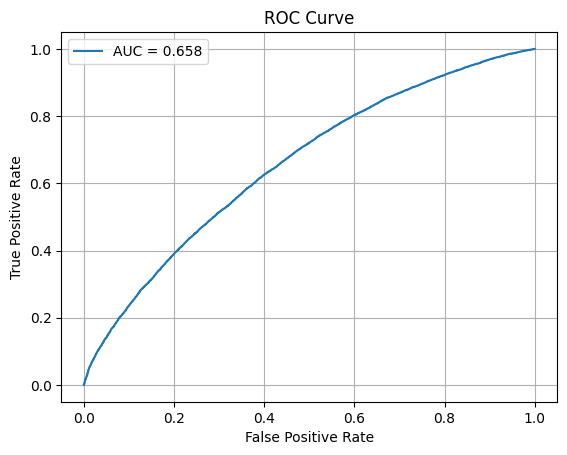

In [55]:
bbh_pred = AE.predict(bbh_test)
bg_pred = AE.predict(background_test)
bbh_mse = np.mean((bbh_pred - bbh_test)**2, axis=(1,2))
bg_mse = np.mean((bg_pred - background_test)**2, axis=(1,2))
test_result = np.concatenate([bg_mse,bbh_mse])
true = np.concatenate([np.zeros(bg_pred.shape[0]),np.ones(bbh_pred.shape[0])])
print(min(bbh_mse),max(bbh_mse),np.mean(bbh_mse))
print(min(bg_mse),max(bg_mse),np.mean(bg_mse))

fpr, tpr, thresholds = roc_curve(true, test_result)
auc_bbh = roc_auc_score(true, test_result)
plt.plot(fpr, tpr,label=f'AUC = {auc_bbh:.3f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
0.0001282599179135165 0.021579220379459096 0.0004016737667423884
0.00020908992371638458 0.009499868113902823 0.00045216597204765827


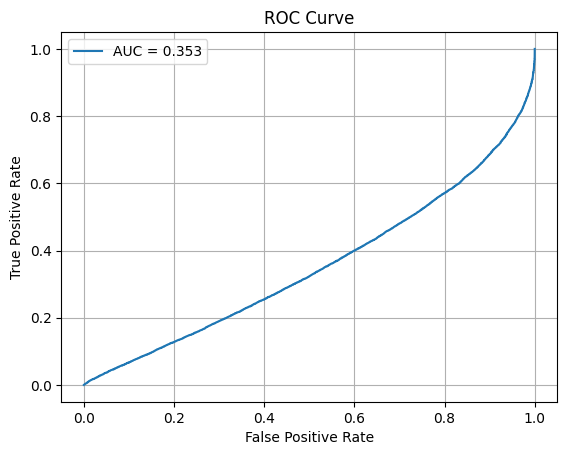

In [56]:
sglf_pred = AE.predict(sglf_test)
sglf_mse = np.mean((sglf_pred - sglf_test)**2, axis=(1,2))
test_result = np.concatenate([bg_mse,sglf_mse])
true = np.concatenate([np.zeros(bg_pred.shape[0]),np.ones(sglf_pred.shape[0])])
print(min(sglf_mse),max(sglf_mse),np.mean(sglf_mse))
print(min(bg_mse),max(bg_mse),np.mean(bg_mse))

fpr, tpr, thresholds = roc_curve(true, test_result)
auc_sglf = roc_auc_score(true, test_result)
plt.plot(fpr, tpr,label=f'AUC = {auc_sglf:.3f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
0.00020776114939669423 0.01564698106834068 0.0004818752909778492
0.0002134166163605536 0.042412662699743635 0.0004964855763011743


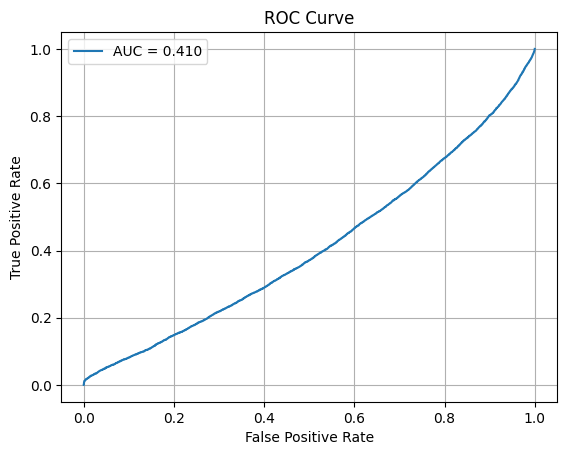

In [57]:
test_pred = AE.predict(signal_test_data)
bg_pred = AE.predict(background_test_data)
test_mse = np.mean((test_pred - signal_test_data)**2, axis=(1,2))
bg_mse = np.mean((bg_pred - background_test_data)**2, axis=(1,2))
test_result = np.concatenate([bg_mse,test_mse])
true = np.concatenate([np.zeros(bg_pred.shape[0]),np.ones(test_pred.shape[0])])
print(min(test_mse),max(test_mse),np.mean(test_mse))
print(min(bg_mse),max(bg_mse),np.mean(bg_mse))

fpr, tpr, thresholds = roc_curve(true, test_result)
auc_sg = roc_auc_score(true, test_result)
plt.plot(fpr, tpr,label=f'AUC = {auc_sg:.3f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.show()

In [58]:
print(auc_bbh,auc_sglf,auc_sg)

0.6576920225 0.35327711999999994 0.41002044000000004


In [59]:
# save_dir = '/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_save'

# param_set = [
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 61, 'f2': 22, 'f5': 2, 'k1': 9,  'k2': 15, 'k3': 24, 'k4': 4,  'k5': 6,  'lr': 0.001, 's1': 1, 's2': 2},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 52, 'f2': 29, 'f5': 2, 'k1': 16, 'k2': 6,  'k3': 8,  'k4': 25, 'k5': 4,  'lr': 0.001, 's1': 1, 's2': 2},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 36, 'f2': 29, 'f5': 2, 'k1': 7,  'k2': 14, 'k3': 15, 'k4': 7,  'k5': 3,  'lr': 0.001, 's1': 1, 's2': 2},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 60, 'f2': 21, 'f5': 2, 'k1': 10, 'k2': 34, 'k3': 26, 'k4': 3,  'k5': 8,  'lr': 0.001, 's1': 1, 's2': 1},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 38, 'f2': 28, 'f5': 2, 'k1': 22, 'k2': 21, 'k3': 27, 'k4': 31, 'k5': 8,  'lr': 0.001, 's1': 1, 's2': 2},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 40, 'f2': 14, 'f5': 2, 'k1': 4,  'k2': 8,  'k3': 20, 'k4': 29, 'k5': 8,  'lr': 0.001, 's1': 1, 's2': 1},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 62, 'f2': 16, 'f5': 2, 'k1': 4,  'k2': 14, 'k3': 37, 'k4': 34, 'k5': 5,  'lr': 0.001, 's1': 1, 's2': 2}
# ]

# for i, params in enumerate(param_set):
#     autoencoder = Autoencoder(**params, input_shape=(200, 2))
#     autoencoder.build_model()
#     autoencoder.model_.fit(
#         x_train, x_train,
#         epochs=params['epochs'],
#         batch_size=params['batch_size'],
#         verbose=1,
#         callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
#     )
#     autoencoder.model_.save(f"/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_save/model_{i}.keras")
#     print(f"✅ Saved model_{i}.keras")

In [60]:
# def eval(model, bg, anomaly):
#     bg_pred = model.predict(bg)
#     anomaly_pred = model.predict(anomaly)
#     bg_mse = np.mean((bg_pred - bg)**2, axis=(1,2))
#     anomaly_mse = np.mean((anomaly_pred - anomaly)**2, axis=(1,2))

#     true_val = np.concatenate((np.zeros(bg.shape[0]),np.ones(anomaly.shape[0])))
#     pred_val = np.concatenate((bg_mse, anomaly_mse))

#     fpr, tpr, thresholds = roc_curve(true_val, pred_val)
#     auc_score = auc(fpr, tpr)
#     return auc_score

# # def eval(model, bg, anomaly):
# #     bg_pred = model.predict(bg)
# #     anomaly_pred = model.predict(anomaly)

# #     bg_mse = np.mean((bg_pred - bg) ** 2, axis=(1, 2))
# #     anomaly_mse = np.mean((anomaly_pred - anomaly) ** 2, axis=(1, 2))

# #     true_val = np.concatenate((np.zeros(bg.shape[0]), np.ones(anomaly.shape[0])))
# #     pred_val = np.concatenate((bg_mse, anomaly_mse))

# #     auc = roc_auc_score(true_val, pred_val)
# #     return auc

# model_files = glob.glob("/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_save/model_*.keras")
# model_files = sorted(model_files, key=lambda x: int(re.search(r"model_(\d+).keras", x).group(1)))
# for model_file in model_files:
#     model = keras_load_model(model_file)
#     auc_bbh = eval(model,background_test,bbh_test)
#     auc_sglf = eval(model,background_test,sglf_test)
#     auc_test = eval(model,background_test_data, signal_test_data)
#     print(f"✅ Evaluation of model {model_file}: BBH AUC = {auc_bbh}, SG AUC = {auc_sglf}, Test AUC = {auc_test}")

